In this notebook I will extract the density of the functional group that might be in the active layer.


In [4]:
import os
import numpy as np
import pandas as pd
from scipy import signal
from scipy import optimize
from scipy import linalg
from scipy.interpolate import UnivariateSpline
import matplotlib as mpl
import matplotlib.pyplot as plt
import array as arr
import seaborn as sns
import random
import pylab
import glob
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import datetime
import cartopy.crs as ccrs
import cartopy
import warnings


import inverse_method_funs_med as inv
import sb_tools

%matplotlib inline

In [5]:
sns.set_theme(style="whitegrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

plt.rcParams['font.size']= 15
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.labelsize'] = 15

warnings.simplefilter("ignore")

savefigs_path= 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/CJFAS_manuscript/Figs/'
savefigjpg_path= 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/CJFAS_manuscript/Figs/'

# Read scattering models
Import species backscattering cross section matrix

In [6]:
# Sigmabs from ZooScatR model runs + viscous elactic model for mean of fish larvae model by ve=True)
fname_sim = '../ZooScatStuff/my_simplified_data_11072022.feather'

specs, freqs_sim, sig_bs_mean, ci_boot = inv.read_scatteringmodelsimulations(fname_sim, nsim=1000, ve=True)

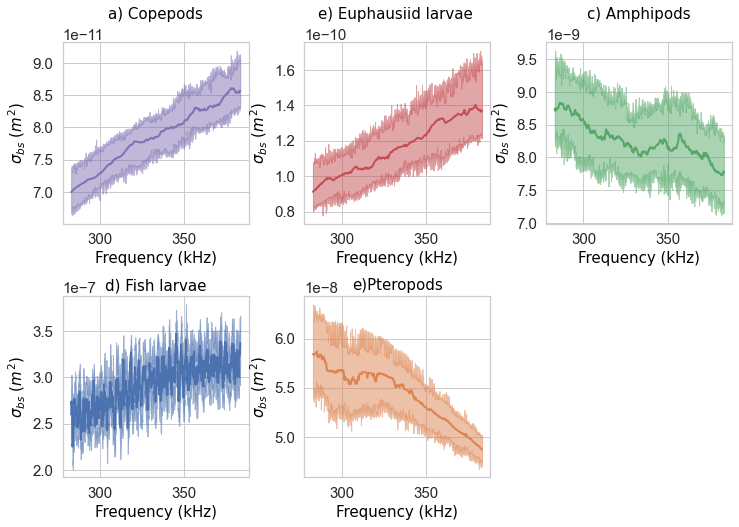

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=.4, wspace=0.3)
axes = axes.flatten()
title_letter= ['a) ','b) ','c) ','d) ','e)', 'f']

color_order = [4,3,2,0,1]
for ind in range(len(specs)):
    axes[ind].plot(freqs_sim,sig_bs_mean[:,ind], linewidth=2, c=sns.color_palette()[color_order[ind]])
    axes[ind].fill_between(freqs_sim,ci_boot[0,:,ind],ci_boot[1,:,ind],alpha=0.5,color=sns.color_palette()[color_order[ind]])
    
    if ind < 3:
        title_str = title_letter[ind]+specs[ind]+'\n'
    else:
        title_str = title_letter[ind]+specs[ind]
    axes[ind].set_title(title_str, title_font)    
    #axes[ind].tick_params(labelsize=13)
    axes[ind].set_ylabel('$\sigma_{bs}$ ($m^{2}$)', axis_font)
    axes[ind].set_xlabel('Frequency (kHz)', axis_font)
    
axes[1].set_title('e) Euphausiid larvae \n', title_font)
axes[5].remove()
#plt.plot(freqs_sim, freqs_sim**4)
#plt.legend(specs, fontsize=16)
#axes[0].set_ylabel('Cross-Sectional Backscatter ($m^{2}$)', axis_font)

fig.savefig(savefigs_path+'FigureS2.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigjpg_path+'FigureS2.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')


# Select relevant simulation frequencies

In [8]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/ssl_GLIDER2018*Widebandfrequencyexport*.csv')

sv_all = np.zeros((1001,0))
times = np.zeros((0))

freqs_EV, sv_out_no, times_out_no = inv.read_widebandfrequencyresponse(fname_EV[0])
sv_all = np.zeros((len(freqs_EV),0))
times = np.zeros((0))

In [9]:
np.shape(sig_bs_mean)

(1001, 5)

In [10]:
np.where(freqs_sim==freqs_EV)

(array([   0,    1,    2, ...,  998,  999, 1000], dtype=int64),)

In [11]:
sigbs_mean = sig_bs_mean


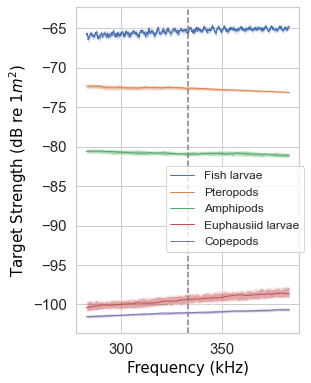

In [68]:
fig, ax =plt.subplots(figsize=(4, 6),facecolor='w', edgecolor='k')
order=[3,4,2,1,0]
for ind in order:
    # Calculate log ci S(TS) = 10*0.434(S(sigbs)/sigbs)
    logci_0 = 10*np.log10(sig_bs_mean[:,ind]) - (10*(0.434*(sig_bs_mean[:,ind]-ci_boot[0,:,ind])/sig_bs_mean[:,ind]))
    logci_1 = 10*np.log10(sig_bs_mean[:,ind]) + 10*(0.434*(ci_boot[1,:,ind]-sig_bs_mean[:,ind])/sig_bs_mean[:,ind])
    
    plt.plot(freqs_EV[:],10*np.log10(sig_bs_mean[:,ind]), linewidth=1, label=specs[ind])
    plt.fill_between(freqs_EV[:],logci_0,logci_1, alpha=0.5)
    
plt.legend(fontsize=12, loc=(0.40,0.25))
plt.ylabel('Target Strength (dB re $1m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.axvline(x=333, linestyle='--', c='grey')
#plt.title('Scattering model results', title_font);

ax.set_rasterized(True)
fig.savefig(savefigs_path+'Figure5.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigjpg_path+'Figure5.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [76]:
# Min and max TS
np.where(10*np.log10(sig_bs_mean[:,3]) == np.max(10*np.log10(sig_bs_mean[:,3])))

(array([621], dtype=int64),)

In [77]:
np.max(10*np.log10(sig_bs_mean[:,3]))

-64.59315513801165

In [75]:
freqs_sim[0]

283.0

# Inverse method
Calculate mean predicted density for each active layer

## Read wideband frequency response
Read the Echoview export of wideband frequency response. sv pulse compressed.

- For each file export 1 estimate with error bars. (August 18th)

And Run a least squares solver

In [15]:
fname_EV = glob.glob('F:/GLIDER2018/Echosounder/Flaket_SSL/ssl_GLIDER2018*Widebandfrequencyexport*.csv')
nfiles = len(fname_EV)
print(nfiles)

sv_all_median = np.zeros((len(freqs_EV), nfiles))
sv_all_q = np.zeros((2,len(freqs_EV), nfiles))
times = np.zeros((0))
density = np.zeros((5, nfiles))
sigbs = sig_bs_mean
for ind in np.arange(nfiles):
    freqs_EV, sv_out, times_out = inv.read_widebandfrequencyresponse(fname_EV[ind])
    times = np.append(times, times_out[0])
    
    # Calculate optimate density combination for each sv(f) export then take the mean of the results
    #density_out = np.zeros([np.shape(sigbs_mean)[1], np.shape(sv_out)[1]])
    #for sv_ind in np.arange(np.shape(sv_out)[1]):
    #    d = optimize.lsq_linear(sigbs, sv_out[:,sv_ind], bounds=(0,np.inf))
    #    density_out[:,sv_ind] =  d.x


    #density_mean[:,ind] = np.mean(density_out,1)
    
    # Calculate the mean of the sv(f) across the SSL and optimize the density estimates based on the average.
    sv_median = np.median(sv_out,1)
    sv_q = np.percentile(sv_out, (25,75), axis=1)
    d = optimize.lsq_linear(sigbs, sv_median, bounds=(0,np.inf))
    density[:,ind] =  d.x
    
    #keep all sv_median and sv_sd
    sv_all_median[:,ind] = sv_median
    sv_all_q[:,:,ind] = sv_q


70


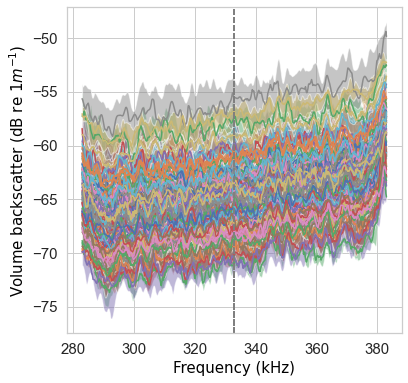

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

for ind in range(nfiles):
    #plt.plot(freqs_EV, 10*np.log10(sv_out))
    plt.plot(freqs_EV, 10*np.log10(sv_all_median[:,ind]));
    plt.fill_between(freqs_EV[:],10*np.log10(sv_all_q[0,:,ind]), 10*np.log10(sv_all_q[1,:,ind]), alpha=0.5);
    plt.ylabel('Volume backscatter (dB re $1m^{-1}$)', axis_font)
    plt.xlabel('Frequency (kHz)', axis_font)
    plt.axvline(x=333, linestyle='--', c='grey')
    
ax.set_rasterized(True)
#plt.savefig(savefigs_path+'Figure5.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
#plt.savefig(savefigjpg_path+'Figure5.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight');

I calculate mean sv(f) from across SSL then calculate optimate density of each taxa. Reduces dependance on variability in each ping sv(f).

Text(0, 0.5, 'Predicted Density (ind/$m^3$)')

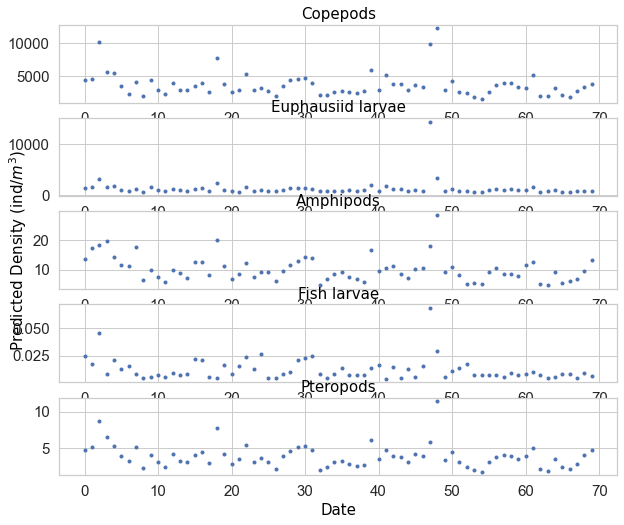

In [17]:
plt.figure(figsize=(10, 10),facecolor='w', edgecolor='k')
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)
plt.xlabel('Functional group', axis_font)
for ind in range(0,len(specs)):
    plt.subplot(len(specs)+1,1,ind+1)
    plt.plot(range(70), density[ind,:], '.')
    #plt.plot(times, density_mean[ind,:], '.k')
    plt.title(specs[ind], title_font)

    plt.xlabel('Date',axis_font)

plt.subplot(len(specs)+1,1,3)
plt.ylabel('Predicted Density (ind/$m^3$)', axis_font)

## Load lat/lon

In [18]:
SB_env_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SB_env_tromsøflaket2018.xlsx',header=0, engine="openpyxl")


In [19]:
SB_env_times = SB_env_df.set_index(['datetime'])

In [20]:
index = []
for ind in range(len(times)):
    ind_index = SB_env_times.index.get_loc(times[ind], method="nearest")
    index = np.append(index, ind_index)

# Make dataframe

In [21]:
data = pd.DataFrame()

for specs_ind in range(len(specs)):
    for ind in range(len(times)):
        SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
        data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            'density': density[specs_ind,ind],
                            'species': specs[specs_ind],                        
                            'source': 'Inverse'}, 
                            'ignore_index=True')

## Add net data

In [22]:
SP_stations_df = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SeaPatchesStations.xlsx',header=0)
tucker_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/TuckerTrawlSP2018_ST7-17.xlsx', header=0)
multinet_density = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/SP_Multinet.xlsx')

In [23]:
#Station 7 from Tucker Trawl
stn = 7
for stn_ind in range(7,18):
    for ind_spec in [0,1,2,3,5]:
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': tucker_density['Station ' + str(stn_ind)][ind_spec],
                            'species': tucker_density['Species'][ind_spec],
                            'source': 'Trawl'}, 
                            'ignore_index=True')
        data = data.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                            'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                            'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                            'density': multinet_density['Stn ' + str(stn_ind)][ind_spec],
                            'species': multinet_density['Species'][ind_spec],
                            'source': 'Net'}, 
                            'ignore_index=True')

# Forward approach

In [24]:
# Select nominal frequency cross sectional backscatter value
nominal_f = np.where(freqs_EV == 333)[0]
# and Re order to match relative abundance order
sigbs_nominal = [sig_bs_mean[nominal_f,2][0],sig_bs_mean[nominal_f,0][0],sig_bs_mean[nominal_f,1][0],sig_bs_mean[nominal_f,3][0],sig_bs_mean[nominal_f,4][0]]


In [25]:
# Select volume backscatter at nominal frequency
sv_nominal = sv_all_median[nominal_f, :]

In [26]:
print('Min Sv(333): '+str(10*np.log10(np.min(sv_nominal)))+'. Max Sv(333): '+str(10*np.log10(np.max(sv_nominal))))

Min Sv(333): -70.842759. Max Sv(333): -55.575705


In [27]:
#Calculate average relative abundance between multinet and tucker trawl
data_MT = data[data.source=='Net']
data_TT = data[data.source=='Trawl']
mean_rel_abundance_TT = data_TT.groupby('species').mean()/sum(data_TT.groupby('species').mean()['density'])
mean_rel_abundance_MT = data_MT.groupby('species').mean()/sum(data_MT.groupby('species').mean()['density'])

species_name = mean_rel_abundance_MT.index
relative_abundance = np.mean([mean_rel_abundance_TT['density'],mean_rel_abundance_MT['density']],axis=0)


In [28]:
# Compute cross sectional backscatter for population described by relative abundance
print('Species are :' +str(species_name))
print('Relative abundance:'+str(relative_abundance*100)+'%')
print('Cross sectional backscatter is:'+str(sigbs_nominal))


Species are :Index(['Amphipods', 'Copepods', 'Euphausiid larvae', 'Fish larvae',
       'Pteropods'],
      dtype='object', name='species')
Relative abundance:[ 2.36303484 80.90940935  6.15886952  0.57380302  9.99488328]%
Cross sectional backscatter is:[8.032352457738516e-09, 7.853558138005727e-11, 1.161003900816209e-10, 2.7838894871904695e-07, 5.5173286148318704e-08]


In [29]:
# Compute total density with forward approach

# Calculate the total cross sectional backscatter while accounting for relative abundance in signal
sig_bs_relative = np.sum(relative_abundance*sigbs_nominal)

total_density_forward = sv_nominal/sig_bs_relative

In [30]:
# redistribute among species and add to data frame
for specs_ind in range(len(species_name)):
    for ind in range(len(times)):
        data = data.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            'density': total_density_forward[0,ind]*relative_abundance[specs_ind],
                            'species': species_name[specs_ind],                        
                            'source': 'Forward'}, 
                            'ignore_index=True')

In [31]:
## Add log of data as column
data['log_density']=np.log10(data.density+1)
data['log_density'][np.isnan(data['log_density'])]==0


Series([], Name: log_density, dtype: bool)

## Function to plot significance

In [32]:
# Custom function to draw the diff bars
def label_sig(ind,X1,X2,shift,text):
    
    y = 4.5-shift
    h = 0.1
    col = 'k'
    axes[ind].plot([X1, X1, X2, X2], [y, y+h, y+h, y], lw=1.5, c=col)
    axes[ind].text((X1+X2)*.5, y-0.05, text, ha='center', va='bottom', color=col, size=18)

def label_sig_total(ind,X1,X2,shift,text):

    y = 8.5-shift
    h = 0.15
    col = 'k'
    axes[ind].plot([X1, X1, X2, X2], [y, y+h, y+h, y], lw=1.5, c=col)
    axes[ind].text((X1+X2)*.5, y-0.18, text, ha='center', va='bottom', color=col, size=18)


# Compare densities

In [33]:
df1 = data.groupby(['source','datetime']).sum()['log_density']
data_grouped = df1.reset_index(0).reset_index(drop=True)

df2 = data.groupby(['source','datetime']).sum()['density']
data_grouped_linear = df2.reset_index(0).reset_index(drop=True)


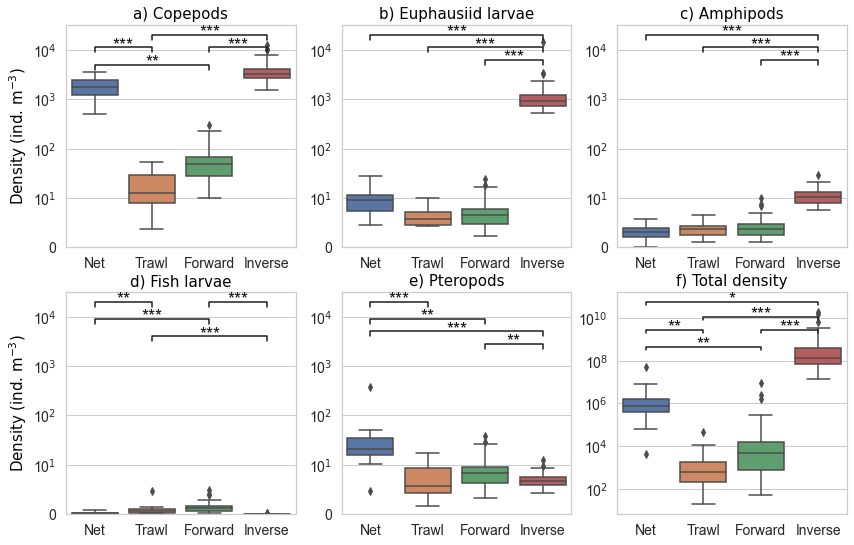

In [34]:
fig, axes = plt.subplots(2,3,figsize=(14,9))
axes = axes.flatten()

title_letter= ['a) ','b) ','c) ','d) ','e) ','f) ']

for ind_spec in range(len(specs)):
    ax_plot = sns.boxplot(data = data[data.species==specs[ind_spec]], 
                          x='source', y='log_density', 
                          ax=axes[ind_spec], 
                          order=['Net', 'Trawl', 'Forward','Inverse'])
    axes[ind_spec].set_title(title_letter[ind_spec] + specs[ind_spec], title_font)
    axes[ind_spec].set_ylim([0,4.5])
    axes[ind_spec].set(xlabel=None)
    axes[ind_spec].set(ylabel=None)
    axes[ind_spec].tick_params(labelsize=14)
    axes[ind_spec].set_yticklabels(['0','10$^1$', '10$^2$', '10$^3$', '10$^4$'])

axes[0].set_ylabel('Density (ind. m$^{-3}$)', axis_font);
axes[3].set_ylabel('Density (ind. m$^{-3}$)', axis_font);

        
# Significance
label_sig(0, 1, 3, 0.30, '***')
label_sig(0, 0, 1, 0.55, '***')
label_sig(0, 2, 3, 0.55, '***')
label_sig(0, 0, 2, 0.9, '**')

label_sig(1, 0, 3, 0.30, '***')
label_sig(1, 1, 3, 0.55, '***')
label_sig(1, 2, 3, 0.80, '***')

label_sig(2, 0, 3, 0.30, '***')
label_sig(2, 1, 3, 0.55, '***')
label_sig(2, 2, 3, 0.80, '***')

label_sig(3, 0, 1, 0.30, '**')
label_sig(3, 2, 3, 0.30, '***')
label_sig(3, 0, 2, 0.65, '***')
label_sig(3, 1, 3, 1, '***')


label_sig(4, 0, 1, 0.30, '***')
label_sig(4, 0, 2, 0.65, '**')
label_sig(4, 0, 3, 0.90, '***')
label_sig(4, 2, 3, 1.15, '**')


    
sns.boxplot(data=data_grouped, x='source', y='log_density', 
                          ax=axes[5], 
                          order=['Net', 'Trawl', 'Forward','Inverse'])

label_sig_total(5, 0, 3, -2.1, '*')
label_sig_total(5, 1, 3, -1.4, '***')
label_sig_total(5, 2, 3, -0.8, '***')
label_sig_total(5, 0, 1, -0.8, '**')
label_sig_total(5, 0, 2, 0, '**')



axes[5].set_title('f) Total density', title_font)
axes[5].set(ylabel=None)
axes[5].set(xlabel=None)
axes[5].tick_params(labelsize=14)
axes[5].set_yticklabels(['10','10$^2$', '10$^4$', '10$^6$', '10$^8$', '10$^{10}$'])

fig.savefig(savefigs_path+'Figure3.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigjpg_path+'Figure3.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')



# Set up per species data

In [35]:
data_spec = pd.DataFrame()

for ind in range(len(times)):
    specs_ind=0
    SB_env_ind = SB_env_times.index.get_loc(times[ind], method="nearest")
    data_spec = data_spec.append({'lat': SB_env_df['latitude (deg)'][SB_env_ind],
                            'lon': SB_env_df['longitude (deg)'][SB_env_ind],
                            'datetime': times[ind],
                            specs[specs_ind]: density[specs_ind, ind],
                            specs[specs_ind+1]: density[specs_ind+1, ind],
                            specs[specs_ind+2]: density[specs_ind+2, ind],
                            specs[specs_ind+3]: density[specs_ind+3, ind],
                            specs[specs_ind+4]: density[specs_ind+4, ind],
                            'source': 'Acoustic'}, 
                            'ignore_index=True')

In [36]:
#Dataframe with all species
for stn_ind in range(7,18):
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        tucker_density['Species'][0]: tucker_density['Station ' + str(stn_ind)][0],
                        tucker_density['Species'][1]: tucker_density['Station ' + str(stn_ind)][1],
                        tucker_density['Species'][2]: tucker_density['Station ' + str(stn_ind)][2],
                        tucker_density['Species'][3]: tucker_density['Station ' + str(stn_ind)][3],
                        tucker_density['Species'][5]: tucker_density['Station ' + str(stn_ind)][5],
                        'source': 'TuckerTrawl'}, 
                        'ignore_index=True')
    data_spec = data_spec.append({'lat' : SP_stations_df['latitude (deg)'][stn_ind-1],
                        'lon' : SP_stations_df['longitude (deg)'][stn_ind-1],
                        'datetime' : SP_stations_df['Datetime'][stn_ind-1],
                        multinet_density['Species'][0]: multinet_density['Stn ' + str(stn_ind)][0],
                        multinet_density['Species'][1]: multinet_density['Stn ' + str(stn_ind)][1],
                        multinet_density['Species'][2]: multinet_density['Stn ' + str(stn_ind)][2],
                        multinet_density['Species'][3]: multinet_density['Stn ' + str(stn_ind)][3],
                        multinet_density['Species'][5]: multinet_density['Stn ' + str(stn_ind)][5],
                        'source': 'Multinet'}, 
                        'ignore_index=True')

## Save for use in R or other notebooks

In [37]:
# Send to R
data.to_feather('.\SSL_density_median.feather')
data_grouped_linear.to_feather('.\SSL_density_grouped_linear.feather')
data_spec.to_feather('.\SSL_density_spec_median.feather')

# Plot relative abundance comparison

In [38]:
fname_topo = "C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/NordNorgeTopo_tromsoflaket.xlsx"

data_MT = data[data.source=='Net']
data_TT = data[data.source=='Trawl']
data_FM = data[data.source=='Forward']
data_IM = data[data.source=='Inverse']



# Print densities

In [39]:
print(data_FM.groupby('species').mean()['density'],data_FM.groupby('species').std()['density']/np.sqrt(70))

species
Amphipods             1.644306
Copepods             56.300394
Euphausiid larvae     4.285618
Fish larvae           0.399278
Pteropods             6.954888
Name: density, dtype: float64 species
Amphipods            0.173593
Copepods             5.943773
Euphausiid larvae    0.452443
Fish larvae          0.042153
Pteropods            0.734245
Name: density, dtype: float64


In [ ]:
sum(data_FM.groupby('species').mean()['density'])

In [40]:
print(data_IM.groupby('species').mean()['density'],data_IM.groupby('species').std()['density']/np.sqrt(70))

species
Amphipods              10.278038
Copepods             3721.794991
Euphausiid larvae    1251.089596
Fish larvae             0.012595
Pteropods               3.912185
Name: density, dtype: float64 species
Amphipods              0.523873
Copepods             226.745464
Euphausiid larvae    201.187029
Fish larvae            0.001189
Pteropods              0.191360
Name: density, dtype: float64


# Load relative abundance values
The net and trawl data include values from the 'Other' category that are not captured with acoustic methods

In [41]:
rel_net= pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/TuckerTrawlSP2018_ST7-17.xlsx', 'Abundance', header=0, skiprows=37, nrows=7)
rel_trawl = pd.read_excel('C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/Tromsøflaket/TuckerTrawlSP2018_ST7-17.xlsx', 'Abundance', header=47, nrows=7)


In [42]:
data_groupspec = data.groupby(['source','species','datetime']).mean()['density']
data_relgroup = data_groupspec.div(data.groupby(['source','datetime']).sum()['density'], axis=0)
rel_forward = data_relgroup['Forward']
rel_inverse = data_relgroup['Inverse']


In [43]:
np.max(data_groupspec['Inverse','Amphipods'])


28.744104576669464

In [44]:
rel_trawl

,Species,Station 7,Station 8,Station 9,Station 10,Station 11,Station 12,Station 13,Station 14,Station 15,Station 16,Station 17,Unnamed: 12
0,Copepods,0.651203,0.301282,0.758065,0.833784,0.584046,0.447552,0.729875,0.430341,0.451613,0.547231,0.253968,NaN
1,Euphausiid larvae,0.111684,0.057692,0.067204,0.066216,0.113960,0.111888,0.107335,0.151703,0.146628,0.210098,0.517460,NaN
2,Amphipods,0.017182,0.042735,0.061828,0.020270,0.071225,0.055944,0.046512,0.049536,0.170088,0.027687,0.057143,NaN
3,Pteropods,0.134021,0.495726,0.029570,0.043243,0.182336,0.332168,0.069767,0.179567,0.129032,0.182410,0.088889,NaN
4,Gelatinous,0.003436,0.000000,0.000000,0.000000,0.005698,0.003497,0.000000,0.003096,0.020528,0.019544,0.038095,NaN
5,Fish larvae,0.024055,0.004274,0.010753,0.001351,0.005698,0.010490,0.010733,0.006192,0.008798,0.008143,0.012698,NaN
6,Other,0.058419,0.098291,0.072581,0.035135,0.037037,0.038462,0.035778,0.179567,0.073314,0.004886,0.031746,NaN


In [45]:
# Net
MT_mean = np.mean(rel_net, axis=1)
MT_std = np.std(rel_net, axis=1)

# Trawl
TT_mean = np.mean(rel_trawl, axis=1)
TT_std = np.std(rel_trawl, axis=1)

# Forward
FM_mean = rel_forward.groupby('species').mean()
FM_std = rel_forward.groupby('species').std()
FM_mean['Other']=0
FM_std['Other']=0

# Inverse
IM_mean = rel_inverse.groupby('species').mean()
IM_std = rel_inverse.groupby('species').std()
IM_mean['Other']=0
IM_std['Other']=0


In [64]:
TT_mean*100

0    54.445081
1    15.107889
2     5.637726
3    16.970271
4     0.853582
5     0.938044
6     6.047407
dtype: float64

In [65]:
print(rel_net.Species, FM_mean*100)

0             Copepods
1    Euphausiid larvae
2            Amphipods
3            Pteropods
4           Gelatinous
5          Fish larvae
6                Other
Name: Species, dtype: object species
Amphipods             2.363035
Copepods             80.909409
Euphausiid larvae     6.158870
Fish larvae           0.573803
Pteropods             9.994883
Other                 0.000000
Name: density, dtype: float64


In [48]:
IM_mean*100

species
Amphipods             0.218829
Copepods             76.648287
Euphausiid larvae    23.049393
Fish larvae           0.000261
Pteropods             0.083230
Other                 0.000000
Name: density, dtype: float64

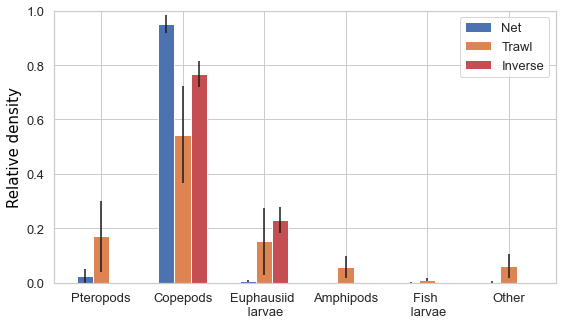

In [49]:
width=0.2
# plot by size
size_order = ['Pteropods', 'Copepods','Euphausiid larvae', 'Amphipods','Fish larvae', 'Other']

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)

for ind in np.arange(len(size_order)):
    size_spec = size_order[ind]
    MT_ind = np.where(rel_net.Species==size_spec)[0][0]
    TT_ind = np.where(rel_net.Species==size_spec)[0][0]
    FM_ind = np.where(FM_mean.index==size_spec)[0][0]
    IM_ind = np.where(IM_mean.index==size_spec)[0][0]

    ax.bar(ind, MT_mean[MT_ind], width, yerr = MT_std[MT_ind], color=sns.color_palette()[0])
    ax.bar(ind+width, TT_mean[TT_ind], width, yerr=TT_std[TT_ind], color=sns.color_palette()[1])
    #ax.bar(ind+width+width, FM_mean[FM_ind], width, yerr=FM_std[FM_ind], color=sns.color_palette()[2])
    ax.bar(ind+width+width, IM_mean[IM_ind], width, yerr=IM_std[IM_ind],color=sns.color_palette()[3])

ax.set_ylim([0,1])

ax.set_xticks(np.arange(6) + (2*width) / 2)
ax.set_xticklabels(['Pteropods', 'Copepods','Euphausiid \n larvae', 'Amphipods','Fish \n larvae', 'Other'])
ax.tick_params(labelsize=13)
plt.legend(['Net', 'Trawl', 'Inverse'],loc='upper right', fontsize=13)

plt.ylabel('Relative density', axis_font)

ax.set_rasterized(True)
fig.savefig(savefigs_path+'Figure4.pdf', format='pdf', dpi = 300, facecolor='w', bbox_inches='tight')
fig.savefig(savefigjpg_path+'Figure4.jpg', format='jpg', dpi = 300, facecolor='w', bbox_inches='tight')

In [50]:
np.sum(data_IM.groupby('species').mean()['density'])

4987.08740506792

In [51]:
print('Average total density (ind/m3): Acoustics Inverse: '+str(np.sum(data_IM.groupby('species').mean()['density']))+', Multinet: '+str(np.sum(data_MT.groupby('species').mean()['density']))+', Tucker trawl: '+str(np.sum(data_TT.groupby('species').mean()['density']))+', Acoustics Forward: '+str(np.sum(data_FM.groupby('species').mean()['density'])))

Average total density (ind/m3): Acoustics Inverse: 4987.08740506792, Multinet: 1899.690656277056, Tucker trawl: 29.607139354712167, Acoustics Forward: 69.58448307595526


In [52]:
print(data_MT.groupby('species').mean()['density'],data_MT.groupby('species').std()['density']/np.sqrt(11))

species
Amphipods               1.184182
Copepods             1834.309735
Euphausiid larvae       9.386618
Fish larvae             0.054545
Pteropods              54.755576
Name: density, dtype: float64 species
Amphipods              0.264555
Copepods             280.341663
Euphausiid larvae      2.251011
Fish larvae            0.021078
Pteropods             32.655703
Name: density, dtype: float64


In [53]:
print(data_TT.groupby('species').mean()['density'],data_TT.groupby('species').std()['density']/np.sqrt(11))

species
Amphipods             1.380798
Copepods             19.321761
Euphausiid larvae     3.500637
Fish larvae           0.338923
Pteropods             5.065019
Name: density, dtype: float64 species
Amphipods            0.261947
Copepods             5.028031
Euphausiid larvae    0.672744
Fish larvae          0.162768
Pteropods            1.494440
Name: density, dtype: float64


In [54]:
data_IM.groupby('species').mean()['density']

species
Amphipods              10.278038
Copepods             3721.794991
Euphausiid larvae    1251.089596
Fish larvae             0.012595
Pteropods               3.912185
Name: density, dtype: float64

In [55]:
# Average overall density per method
print('Inverse overall average density '+ str(np.sum(data_IM.groupby('species').mean()['density']))+'ind m$^{-3}$')

# Average overall density per method
print('Forward overall average density '+ str(np.sum(data_FM.groupby('species').mean()['density']))+'ind m$^{-3}$')


# calculate in speadsheet to include OTHER taxonomic groups
print('Multinet overall average density '+ str(np.sum(data_MT.groupby('species').mean()['density']))+'ind m$^{-3}$')

# calculate in spreadsheet to include OTHER taxonomic groups
print('Tucker trawl overall average density '+ str(np.sum(data_TT.groupby('species').mean()['density']))+'ind m$^{-3}$')

Inverse overall average density 4987.08740506792ind m$^{-3}$
Forward overall average density 69.58448307595526ind m$^{-3}$
Multinet overall average density 1899.690656277056ind m$^{-3}$
Tucker trawl overall average density 29.607139354712167ind m$^{-3}$


In [56]:
data[data.species=='Krill'].groupby('source').mean()['density']

Series([], Name: density, dtype: float64)

# Size distributions

### Total length distributions acoustics

In [57]:
# Radius R3 distribution
# Values from lengthDist.Rmd. 
# For gamma distirbution scale = 1/rate. alpha = shape.
# For log normal distribution. s=sigma(logstd), scale=e^(mu or logmean)

# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,15,0.1)
lima_dist = stats.gamma.pdf(x, a=5.4,scale=1/4.6) #Full length not radius
cope_dist = stats.norm.pdf(x, loc=2.62, scale=0.09) # 
amphi_dist = stats.gamma.pdf(x, a=10.3, scale=1/2.3)
euphau_dist = stats.lognorm.pdf(x, s=0.3, scale=np.exp(1.5))
fish_dist = stats.lognorm.pdf(x, s=0.28, scale = np.exp(2.02)) #approximately calculated from converted model swimbladder distribution into total length distributions

### Total length distibutions tucker

In [58]:

# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,15,0.1)
lima_dist_tuck = stats.gamma.pdf(x, a=17.5,scale=1/14.1) #Full length not radius
cope_dist_tuck = stats.gamma.pdf(x, a=0, scale=0)
amphi_dist_tuck = stats.gamma.pdf(x, a=10.9, scale=1/2.5)
euphau_dist_tuck = stats.lognorm.pdf(x, s=0.3, scale=np.exp(1.5)) # Same as acoustic
fish_dist_tuck = stats.lognorm.pdf(x, s=0.31, scale = np.exp(2.18)) #approximately calculated from converted model swimbladder distribution into total length distributions

### Total length distributions mulitnet

In [59]:

# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,15,0.1)
lima_dist_multi = stats.gamma.pdf(x, a=5.6,scale=1/3.8) #Full length not radius
cope_dist_multi = stats.norm.pdf(x, loc=2.62, scale=0.09)
amphi_dist_multi = stats.gamma.pdf(x, a=9.8, scale=1/2.1)
euphau_dist_multi = stats.gamma.pdf(x, a=14.7, scale=1/2.01)
fish_dist_multi = stats.lognorm.pdf(x, s=0.48, scale = np.exp(1.97)) #approximately calculated from converted model swimbladder distribution into total length distributions

### Plot distributions

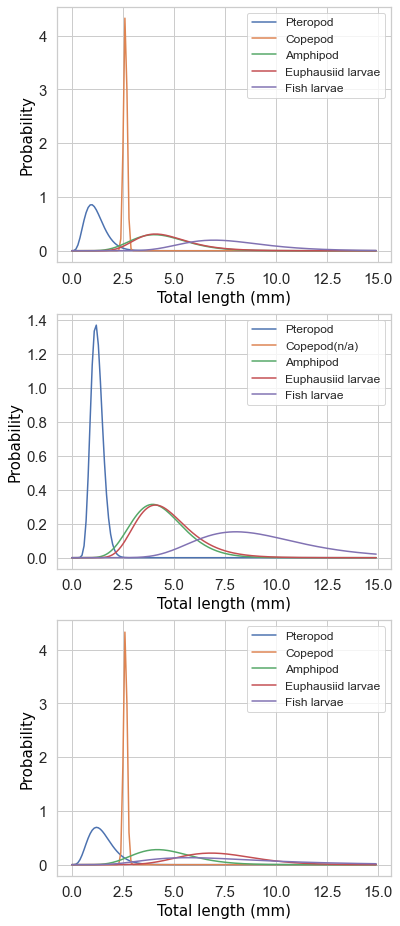

In [60]:
plt.figure(figsize=(6,16))
ax = plt.subplot(3,1,1)
plt.plot(x, lima_dist, label='Pteropod')
plt.plot(x, cope_dist, label='Copepod')
plt.plot(x, amphi_dist, label='Amphipod')
plt.plot(x, euphau_dist, label='Euphausiid larvae')
plt.plot(x, fish_dist, label='Fish larvae')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=12)

ax = plt.subplot(3,1,2)
plt.plot(x, lima_dist_tuck, label='Pteropod')
plt.plot(x, cope_dist_tuck, label='Copepod(n/a)')
plt.plot(x, amphi_dist_tuck, label='Amphipod')
plt.plot(x, euphau_dist_tuck, label='Euphausiid larvae')
plt.plot(x, fish_dist_tuck, label='Fish larvae')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=12)

ax = plt.subplot(3,1,3)
plt.plot(x, lima_dist_multi, label='Pteropod')
plt.plot(x, cope_dist_multi, label='Copepod')
plt.plot(x, amphi_dist_multi, label='Amphipod')
plt.plot(x, euphau_dist_multi, label='Euphausiid larvae')
plt.plot(x, fish_dist_multi, label='Fish larvae')
plt.xlabel('Total length (mm)', axis_font)
plt.ylabel('Probability', axis_font);
plt.legend(fontsize=12)

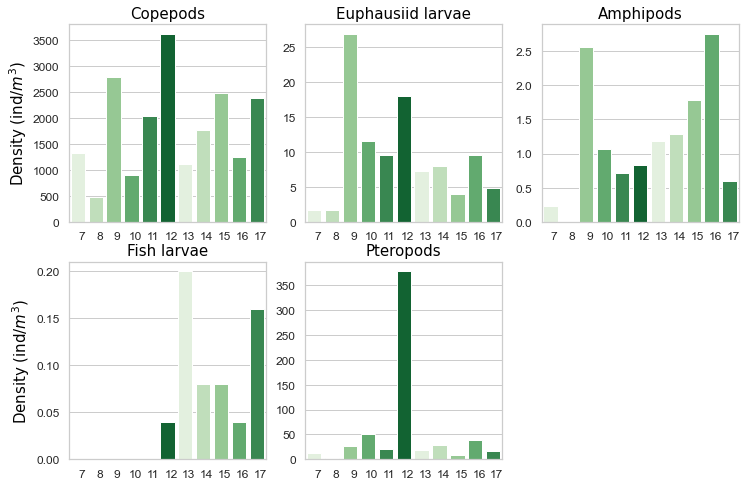

In [61]:
fig = plt.figure(figsize=(12,8))
cmap = sns.color_palette("Greens")
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.barplot(data = data_MT[data.species==specs[ind_spec]], x='lon', y='density', palette=cmap)
    ax.set_title(specs[ind_spec], title_font)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    
    ax.set_xticks(np.arange(11) + (2*width) / 2)
    ax.set_xticklabels(['7','8','9','10','11','12','13','14','15','16','17'])
    ax.tick_params(labelsize=12)


    if ind_spec==0:
        ax.set_ylabel('Density (ind/$m^3$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('Density (ind/$m^3$)', axis_font);
        


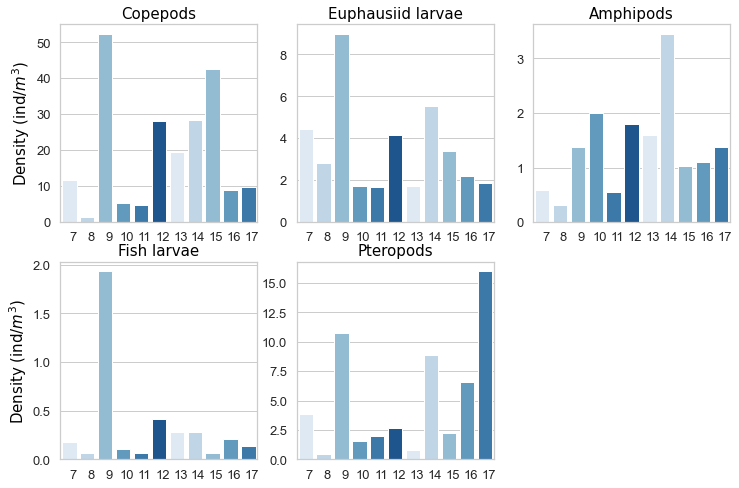

In [62]:
fig = plt.figure(figsize=(12,8))
for ind_spec in range(len(specs)):
    ax = plt.subplot(2,3,ind_spec+1)
    splot = sns.barplot(data = data_TT[data.species==specs[ind_spec]], 
                        x='lon', 
                        y='density', 
                        palette=sns.color_palette("Blues"))
    ax.set_title(specs[ind_spec], title_font)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    
    ax.set_xticks(np.arange(11) + (2*width) / 2)
    ax.set_xticklabels(['7','8','9','10','11','12','13','14','15','16','17'])
    ax.tick_params(labelsize=13)
    
    if ind_spec==0:
        ax.set_ylabel('Density (ind/$m^3$)', axis_font);
    if ind_spec==3:
        ax.set_ylabel('Density (ind/$m^3$)', axis_font);
        


